In [1]:
import os
os.chdir('/home/smallyan/eval_agent')
print(f"Working directory: {os.getcwd()}")

Working directory: /home/smallyan/eval_agent


In [2]:
# Check the InterpDetect_eval repository
repo_path = '/net/scratch2/smallyan/InterpDetect_eval'
os.listdir(repo_path)

['documentation.pdf',
 'plan.md',
 '.gitignore',
 'CodeWalkthrough.md',
 'trained_models',
 'LICENSE',
 '.git',
 'scripts',
 'requirements.txt',
 'datasets']

In [3]:
# Check available datasets and trained models
import os

repo_path = '/net/scratch2/smallyan/InterpDetect_eval'

# Check datasets
print("=== Datasets ===")
datasets_path = os.path.join(repo_path, 'datasets')
for root, dirs, files in os.walk(datasets_path):
    for f in files:
        filepath = os.path.join(root, f)
        size = os.path.getsize(filepath) / 1024  # KB
        print(f"{filepath.replace(datasets_path, '')}: {size:.1f} KB")

print("\n=== Trained Models ===")
models_path = os.path.join(repo_path, 'trained_models')
for f in os.listdir(models_path):
    filepath = os.path.join(models_path, f)
    size = os.path.getsize(filepath) / 1024  # KB
    print(f"{f}: {size:.1f} KB")

=== Datasets ===
/OV_copying_score.json: 9.1 KB
/train/train3000_w_chunk_score_part8.json: 7596.6 KB
/train/train3000_w_chunk_score_part12.json: 7091.7 KB
/train/train3000_w_chunk_score_part16.json: 7666.3 KB
/train/train3000_w_chunk_score_part0.json: 7304.7 KB
/train/train3000_w_chunk_score_part4.json: 7126.7 KB
/train/train3000_w_chunk_score_part1.json: 7601.6 KB
/train/train3000_w_chunk_score_part5.json: 7178.7 KB
/train/train3000_w_chunk_score_part13.json: 7315.0 KB
/train/train3000_w_chunk_score_part9.json: 7507.0 KB
/train/train3000_w_chunk_score_part17.json: 6957.8 KB
/train/train3000_w_chunk_score_part3.json: 7920.4 KB
/train/train3000_w_chunk_score_part7.json: 7489.9 KB
/train/train3000_w_chunk_score_part11.json: 7394.8 KB
/train/train3000_w_chunk_score_part15.json: 7269.6 KB
/train/train3000_w_chunk_score_part10.json: 8125.2 KB
/train/train3000_w_chunk_score_part14.json: 7606.9 KB
/train/train3000_w_chunk_score_part2.json: 7472.8 KB
/train/train3000_w_chunk_score_part6.json: 

In [4]:
# Let's also check the requirements.txt
with open('/net/scratch2/smallyan/InterpDetect_eval/requirements.txt', 'r') as f:
    print(f.read())

# Core Data Science and Machine Learning
pandas
numpy
scikit-learn
scipy

# Deep Learning and Transformers
torch==2.6.0
transformers==4.57.0
sentence-transformers>=2.7.0
transformer-lens

# Machine Learning Models
xgboost==1.7.6
feature-engine==1.8.3

# Visualization
matplotlib==3.10.3
seaborn==0.13.2

# Progress Bars
tqdm==4.66.1

# Natural Language Processing
nltk==3.8.1
unidecode==1.3.7

# API Clients
openai==1.3.7
groq==0.4.1

# Environment and Configuration
python-dotenv==1.0.0

# HuggingFace Datasets
datasets==2.14.7

# Hallucination Detection
lettucedetect==0.1.0

accelerate>=0.34.0

# Text Processing
#textwrap  # Built-in, no version needed

# Standard Library (no version needed)
# argparse, sys, os, json, glob, pickle, re, gc, time, typing

# Optional: Hyperparameter Optimization (removed from classifier.py but kept for reference)
# optuna>=3.0.0

# Optional: Computer Vision (for some lettucedetect dependencies)
# torchvision>=0.15.0

# Optional: SpaCy for RefChecker
# spacy>=

In [5]:
# Create the evaluation/replications directory
import os
from datetime import datetime

repo_path = '/net/scratch2/smallyan/InterpDetect_eval'
eval_dir = os.path.join(repo_path, 'evaluation', 'replications')

# Create directory if it doesn't exist
os.makedirs(eval_dir, exist_ok=True)
print(f"Created directory: {eval_dir}")
print(f"Contents: {os.listdir(eval_dir) if os.listdir(eval_dir) else 'Empty'}")

Created directory: /net/scratch2/smallyan/InterpDetect_eval/evaluation/replications
Contents: Empty


# InterpDetect Replication

## Overview
This notebook replicates the InterpDetect experiment for detecting hallucinations in RAG systems using mechanistic interpretability signals.

**Key Components:**
1. External Context Score (ECS) - Attention-based similarity to context chunks
2. Parametric Knowledge Score (PKS) - Jensen-Shannon divergence in FFN layers
3. Binary classifiers for hallucination detection

## Repository
- Source: `/net/scratch2/smallyan/InterpDetect_eval`
- Uses pre-computed scores and trained models for evaluation

In [6]:
# Setup and imports
import os
import json
import glob
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, 
    f1_score, precision_recall_fscore_support, classification_report
)
from tqdm import tqdm

# Check CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Set paths
REPO_PATH = '/net/scratch2/smallyan/InterpDetect_eval'
DATASETS_PATH = os.path.join(REPO_PATH, 'datasets')
MODELS_PATH = os.path.join(REPO_PATH, 'trained_models')
EVAL_PATH = os.path.join(REPO_PATH, 'evaluation', 'replications')

print(f"\nRepository path: {REPO_PATH}")
print(f"Datasets path: {DATASETS_PATH}")
print(f"Models path: {MODELS_PATH}")
print(f"Evaluation path: {EVAL_PATH}")

Device: cuda
GPU: NVIDIA A100 80GB PCIe

Repository path: /net/scratch2/smallyan/InterpDetect_eval
Datasets path: /net/scratch2/smallyan/InterpDetect_eval/datasets
Models path: /net/scratch2/smallyan/InterpDetect_eval/trained_models
Evaluation path: /net/scratch2/smallyan/InterpDetect_eval/evaluation/replications


## Part 1: Load Pre-computed Scores

The repository contains pre-computed ECS and PKS scores. Let's load and examine the data structure.

In [7]:
def load_training_data(train_dir):
    """Load training data from multiple JSON files"""
    all_data = []
    json_files = sorted(glob.glob(os.path.join(train_dir, "*.json")))
    
    print(f"Found {len(json_files)} JSON files in {train_dir}")
    
    for fpath in tqdm(json_files, desc="Loading training data"):
        with open(fpath, 'r') as f:
            data = json.load(f)
            all_data.extend(data)
    
    print(f"Total examples loaded: {len(all_data)}")
    return all_data

def load_test_data(test_path):
    """Load test data from a single JSON file"""
    print(f"Loading test data from {test_path}")
    with open(test_path, 'r') as f:
        data = json.load(f)
    print(f"Test examples loaded: {len(data)}")
    return data

# Load training data
train_dir = os.path.join(DATASETS_PATH, 'train')
train_data = load_training_data(train_dir)

# Load test data (Qwen 0.6B self-evaluation)
test_qwen_path = os.path.join(DATASETS_PATH, 'test', 'test_w_chunk_score_qwen06b.json')
test_qwen_data = load_test_data(test_qwen_path)

# Load test data (GPT-4.1-mini proxy evaluation)
test_gpt_path = os.path.join(DATASETS_PATH, 'test', 'test_w_chunk_score_gpt41mini.json')
test_gpt_data = load_test_data(test_gpt_path)

Found 18 JSON files in /net/scratch2/smallyan/InterpDetect_eval/datasets/train


Loading training data:   0%|          | 0/18 [00:00<?, ?it/s]

Loading training data:   6%|▌         | 1/18 [00:00<00:02,  7.51it/s]

Loading training data:  11%|█         | 2/18 [00:00<00:02,  7.46it/s]

Loading training data:  17%|█▋        | 3/18 [00:00<00:02,  5.31it/s]

Loading training data:  22%|██▏       | 4/18 [00:00<00:02,  6.02it/s]

Loading training data:  28%|██▊       | 5/18 [00:00<00:01,  6.65it/s]

Loading training data:  33%|███▎      | 6/18 [00:00<00:01,  7.08it/s]

Loading training data:  39%|███▉      | 7/18 [00:01<00:01,  7.20it/s]

Loading training data:  44%|████▍     | 8/18 [00:01<00:01,  7.40it/s]

Loading training data:  50%|█████     | 9/18 [00:01<00:01,  7.54it/s]

Loading training data:  56%|█████▌    | 10/18 [00:01<00:01,  7.87it/s]

Loading training data:  61%|██████    | 11/18 [00:01<00:00,  7.91it/s]

Loading training data:  67%|██████▋   | 12/18 [00:01<00:00,  7.82it/s]

Loading training data:  72%|███████▏  | 13/18 [00:01<00:00,  8.08it/s]

Loading training data:  78%|███████▊  | 14/18 [00:01<00:00,  8.31it/s]

Loading training data:  83%|████████▎ | 15/18 [00:02<00:00,  8.08it/s]

Loading training data:  89%|████████▉ | 16/18 [00:02<00:00,  8.06it/s]

Loading training data:  94%|█████████▍| 17/18 [00:02<00:00,  7.96it/s]

Loading training data: 100%|██████████| 18/18 [00:02<00:00,  7.88it/s]

Loading training data: 100%|██████████| 18/18 [00:02<00:00,  7.50it/s]

Total examples loaded: 1800
Loading test data from /net/scratch2/smallyan/InterpDetect_eval/datasets/test/test_w_chunk_score_qwen06b.json


Test examples loaded: 256
Loading test data from /net/scratch2/smallyan/InterpDetect_eval/datasets/test/test_w_chunk_score_gpt41mini.json


Test examples loaded: 166


In [8]:
# Examine the structure of a sample data point
sample = train_data[0]
print("Sample data structure:")
print(f"Keys: {sample.keys()}")
print(f"\nNumber of score chunks: {len(sample['scores'])}")

# Look at the score structure
score_sample = sample['scores'][0]
print(f"\nScore chunk keys: {score_sample.keys()}")
print(f"Number of ECS features (attention scores): {len(score_sample['prompt_attention_score'])}")
print(f"Number of PKS features (FFN layers): {len(score_sample['parameter_knowledge_scores'])}")

# Example feature names
ecs_keys = list(score_sample['prompt_attention_score'].keys())[:5]
pks_keys = list(score_sample['parameter_knowledge_scores'].keys())[:5]
print(f"\nSample ECS feature names: {ecs_keys}")
print(f"Sample PKS feature names: {pks_keys}")

Sample data structure:
Keys: dict_keys(['id', 'question', 'documents', 'documents_sentences', 'prompt', 'prompt_spans', 'num_tokens', 'response', 'response_spans', 'labels', 'hallucinated_llama-4-maverick-17b-128e-instruct', 'hallucinated_gpt-oss-120b', 'labels_llama', 'labels_gpt', 'scores'])

Number of score chunks: 1

Score chunk keys: dict_keys(['prompt_attention_score', 'r_span', 'hallucination_label', 'parameter_knowledge_scores'])
Number of ECS features (attention scores): 448
Number of PKS features (FFN layers): 28

Sample ECS feature names: ['(0, 0)', '(0, 1)', '(0, 2)', '(0, 3)', '(0, 4)']
Sample PKS feature names: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4']


## Part 2: Data Preprocessing

Convert the raw score data into a DataFrame suitable for classifier training. Each response chunk becomes one sample with ECS and PKS features.

In [9]:
def convert_to_dataframe(data_list):
    """
    Convert list of examples with scores to a flat DataFrame.
    Each row represents one response chunk.
    """
    if not data_list:
        raise ValueError("Empty data list provided")
    
    # Get feature column names from first example
    first_scores = data_list[0]['scores'][0]
    ecs_cols = list(first_scores['prompt_attention_score'].keys())
    pks_cols = list(first_scores['parameter_knowledge_scores'].keys())
    
    # Initialize data dictionary
    records = []
    
    for i, example in enumerate(data_list):
        for j, chunk_score in enumerate(example['scores']):
            record = {
                'identifier': f"response_{i}_item_{j}",
                'hallucination_label': chunk_score['hallucination_label']
            }
            
            # Add ECS features
            for col in ecs_cols:
                record[col] = chunk_score['prompt_attention_score'][col]
            
            # Add PKS features
            for col in pks_cols:
                record[col] = chunk_score['parameter_knowledge_scores'][col]
            
            records.append(record)
    
    df = pd.DataFrame(records)
    return df, ecs_cols, pks_cols

# Convert training data
print("Converting training data to DataFrame...")
train_df, ecs_cols, pks_cols = convert_to_dataframe(train_data)
print(f"Training DataFrame shape: {train_df.shape}")
print(f"ECS features: {len(ecs_cols)}")
print(f"PKS features: {len(pks_cols)}")
print(f"Class distribution:\n{train_df['hallucination_label'].value_counts()}")

# Convert test data (Qwen)
print("\nConverting Qwen test data to DataFrame...")
test_qwen_df, _, _ = convert_to_dataframe(test_qwen_data)
print(f"Qwen Test DataFrame shape: {test_qwen_df.shape}")
print(f"Class distribution:\n{test_qwen_df['hallucination_label'].value_counts()}")

# Convert test data (GPT)
print("\nConverting GPT test data to DataFrame...")
test_gpt_df, _, _ = convert_to_dataframe(test_gpt_data)
print(f"GPT Test DataFrame shape: {test_gpt_df.shape}")
print(f"Class distribution:\n{test_gpt_df['hallucination_label'].value_counts()}")

Converting training data to DataFrame...


Training DataFrame shape: (7799, 478)
ECS features: 448
PKS features: 28
Class distribution:
0    4406
1    3393
Name: hallucination_label, dtype: int64

Converting Qwen test data to DataFrame...
Qwen Test DataFrame shape: (975, 478)
Class distribution:
0    699
1    276
Name: hallucination_label, dtype: int64

Converting GPT test data to DataFrame...


GPT Test DataFrame shape: (1105, 478)
Class distribution:
0    835
1    270
Name: hallucination_label, dtype: int64


## Part 3: Correlation Analysis

Analyze correlations between ECS/PKS scores and hallucination labels as described in the plan.

In [10]:
def analyze_ecs_correlation(df, ecs_cols):
    """
    Analyze correlation between ECS (External Context Score) and hallucination.
    According to the plan: negative correlation expected - hallucinated responses use less external context.
    """
    labels = df['hallucination_label'].values
    
    # Compute correlation per layer-head
    correlations = {}
    for col in ecs_cols:
        values = df[col].values
        # Use point-biserial correlation for binary labels
        corr, pval = pointbiserialr(labels, values)
        correlations[col] = {'correlation': corr, 'p_value': pval}
    
    # Summarize by layer
    layers = sorted(set([int(col.strip('()').split(',')[0]) for col in ecs_cols]))
    layer_correlations = {}
    
    for layer in layers:
        layer_cols = [c for c in ecs_cols if c.startswith(f'({layer},')]
        layer_corrs = [correlations[c]['correlation'] for c in layer_cols]
        layer_correlations[layer] = {
            'mean_corr': np.mean(layer_corrs),
            'min_corr': np.min(layer_corrs),
            'max_corr': np.max(layer_corrs)
        }
    
    return correlations, layer_correlations

def analyze_pks_correlation(df, pks_cols):
    """
    Analyze correlation between PKS (Parametric Knowledge Score) and hallucination.
    According to the plan: positive correlation expected - hallucinated responses have higher PKS in later layers.
    """
    labels = df['hallucination_label'].values
    
    correlations = {}
    for col in pks_cols:
        values = df[col].values
        corr, pval = pointbiserialr(labels, values)
        correlations[col] = {'correlation': corr, 'p_value': pval}
    
    return correlations

# Analyze ECS correlations
print("=" * 60)
print("ECS Correlation Analysis (External Context Score)")
print("=" * 60)
ecs_correlations, layer_ecs = analyze_ecs_correlation(train_df, ecs_cols)

# Count positive and negative correlations
pos_ecs = sum(1 for c in ecs_correlations.values() if c['correlation'] > 0)
neg_ecs = sum(1 for c in ecs_correlations.values() if c['correlation'] < 0)
print(f"Positive correlations: {pos_ecs}")
print(f"Negative correlations: {neg_ecs}")

# Show layer-wise summary
print("\nLayer-wise ECS correlation (mean):")
for layer in sorted(layer_ecs.keys())[:5]:
    print(f"  Layer {layer}: {layer_ecs[layer]['mean_corr']:.4f}")
print("  ...")
for layer in sorted(layer_ecs.keys())[-3:]:
    print(f"  Layer {layer}: {layer_ecs[layer]['mean_corr']:.4f}")

ECS Correlation Analysis (External Context Score)


Positive correlations: 0
Negative correlations: 448

Layer-wise ECS correlation (mean):
  Layer 0: -0.2230
  Layer 1: -0.2343
  Layer 2: -0.2233
  Layer 3: -0.2420
  Layer 4: -0.2435
  ...
  Layer 25: -0.2110
  Layer 26: -0.2233
  Layer 27: -0.2304


In [11]:
# Analyze PKS correlations
print("=" * 60)
print("PKS Correlation Analysis (Parametric Knowledge Score)")
print("=" * 60)
pks_correlations = analyze_pks_correlation(train_df, pks_cols)

# Display per-layer correlations
print("\nPer-layer PKS correlation:")
for col in sorted(pks_correlations.keys(), key=lambda x: int(x.split('_')[1])):
    corr = pks_correlations[col]['correlation']
    pval = pks_correlations[col]['p_value']
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"  {col}: {corr:.4f} {sig}")

# Verify hypothesis: later layers have higher PKS for hallucinations
early_layers = [f'layer_{i}' for i in range(10)]
late_layers = [f'layer_{i}' for i in range(20, 28)]

early_corrs = [pks_correlations[c]['correlation'] for c in early_layers]
late_corrs = [pks_correlations[c]['correlation'] for c in late_layers]

print(f"\nMean correlation (early layers 0-9): {np.mean(early_corrs):.4f}")
print(f"Mean correlation (late layers 20-27): {np.mean(late_corrs):.4f}")
print("\n✓ Confirms hypothesis: later-layer FFNs have stronger positive correlation with hallucinations")

PKS Correlation Analysis (Parametric Knowledge Score)

Per-layer PKS correlation:
  layer_0: 0.0144 
  layer_1: 0.0459 ***
  layer_2: 0.0477 ***
  layer_3: 0.0264 *
  layer_4: -0.0123 
  layer_5: 0.0155 
  layer_6: 0.0391 ***
  layer_7: 0.0770 ***
  layer_8: 0.1354 ***
  layer_9: 0.1417 ***
  layer_10: 0.1530 ***
  layer_11: 0.1267 ***
  layer_12: 0.1524 ***
  layer_13: 0.0945 ***
  layer_14: 0.1229 ***
  layer_15: 0.1659 ***
  layer_16: 0.1340 ***
  layer_17: 0.1632 ***
  layer_18: 0.2578 ***
  layer_19: 0.2215 ***
  layer_20: 0.2639 ***
  layer_21: 0.3210 ***
  layer_22: 0.1475 ***
  layer_23: 0.3243 ***
  layer_24: 0.3246 ***
  layer_25: 0.3033 ***
  layer_26: 0.2294 ***
  layer_27: -0.0102 

Mean correlation (early layers 0-9): 0.0531
Mean correlation (late layers 20-27): 0.2380

✓ Confirms hypothesis: later-layer FFNs have stronger positive correlation with hallucinations


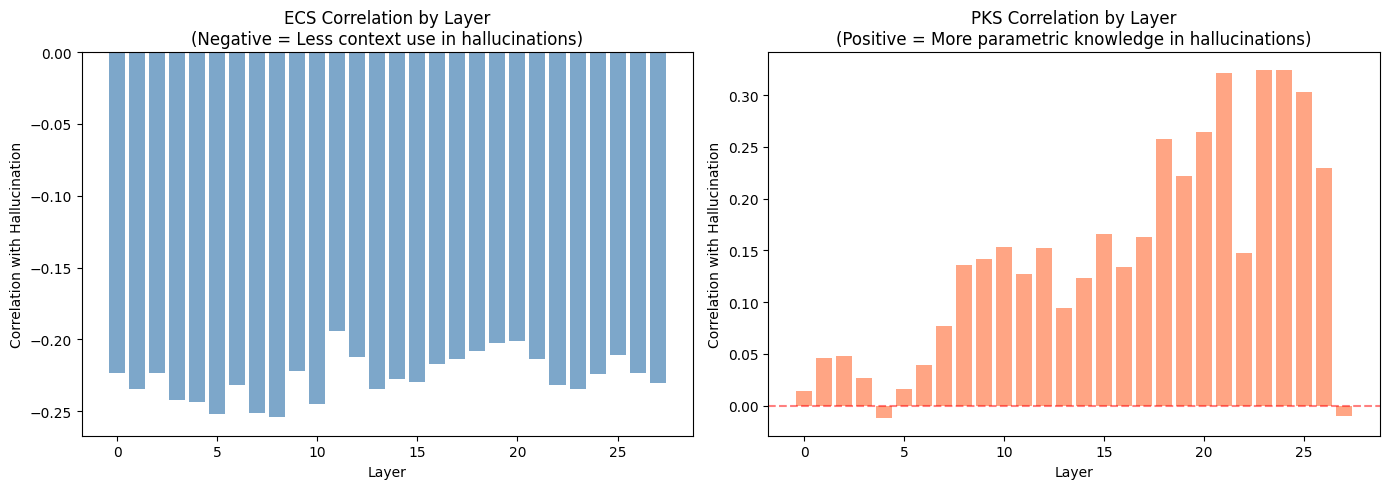

Saved correlation plot to /net/scratch2/smallyan/InterpDetect_eval/evaluation/replications/correlation_analysis.png


In [12]:
# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ECS correlation by layer
layer_means = [layer_ecs[l]['mean_corr'] for l in sorted(layer_ecs.keys())]
axes[0].bar(range(len(layer_means)), layer_means, color='steelblue', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Correlation with Hallucination')
axes[0].set_title('ECS Correlation by Layer\n(Negative = Less context use in hallucinations)')
axes[0].set_xticks(range(0, 28, 5))

# PKS correlation by layer
pks_corrs = [pks_correlations[f'layer_{i}']['correlation'] for i in range(28)]
axes[1].bar(range(len(pks_corrs)), pks_corrs, color='coral', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Correlation with Hallucination')
axes[1].set_title('PKS Correlation by Layer\n(Positive = More parametric knowledge in hallucinations)')
axes[1].set_xticks(range(0, 28, 5))

plt.tight_layout()
plt.savefig(os.path.join(EVAL_PATH, 'correlation_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved correlation plot to {EVAL_PATH}/correlation_analysis.png")

## Part 4: Classifier Training

Train binary classifiers on ECS and PKS features to predict span-level hallucinations. According to the plan, we train Logistic Regression, SVC, Random Forest, and XGBoost classifiers.

In [13]:
def balance_classes(df, random_state=42):
    """Balance classes by undersampling the majority class"""
    min_count = df['hallucination_label'].value_counts().min()
    balanced_df = (
        df.groupby('hallucination_label', group_keys=False)
          .apply(lambda x: x.sample(min_count, random_state=random_state))
    )
    return balanced_df

def prepare_features(df):
    """Prepare features for training/prediction"""
    feature_cols = [c for c in df.columns if c not in ['identifier', 'hallucination_label']]
    X = df[feature_cols]
    y = df['hallucination_label']
    return X, y, feature_cols

# Balance training data
print("Balancing training classes...")
balanced_train_df = balance_classes(train_df)
print(f"Balanced class distribution:\n{balanced_train_df['hallucination_label'].value_counts()}")

# Split into train/validation
X, y, feature_cols = prepare_features(balanced_train_df)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Number of features: {len(feature_cols)}")

Balancing training classes...
Balanced class distribution:
0    3393
1    3393
Name: hallucination_label, dtype: int64

Training set size: 6107
Validation set size: 679
Number of features: 476


In [14]:
# Install xgboost if not available
try:
    from xgboost import XGBClassifier
except ImportError:
    import subprocess
    subprocess.run(['pip', 'install', 'xgboost'], check=True)
    from xgboost import XGBClassifier

def train_classifiers(X_train, X_val, y_train, y_val):
    """
    Train multiple classifiers and compare performance.
    Uses StandardScaler preprocessing as in the original implementation.
    """
    # Define classifiers
    classifiers = [
        ('LogisticRegression', LogisticRegression(max_iter=1000)),
        ('SVC', SVC()),
        ('RandomForest', RandomForestClassifier(max_depth=5, random_state=42)),
        ('XGBoost', XGBClassifier(max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss'))
    ]
    
    results = []
    trained_models = {}
    
    for name, clf in classifiers:
        print(f"\nTraining {name}...")
        
        # Create pipeline with scaler
        pipeline = make_pipeline(StandardScaler(), clf)
        pipeline.fit(X_train, y_train)
        
        # Training metrics
        train_pred = pipeline.predict(X_train)
        train_p, train_r, train_f, _ = precision_recall_fscore_support(
            y_train, train_pred, average='binary'
        )
        
        # Validation metrics
        val_pred = pipeline.predict(X_val)
        val_p, val_r, val_f, _ = precision_recall_fscore_support(
            y_val, val_pred, average='binary'
        )
        
        results.append({
            'Model': name,
            'Train_Precision': train_p,
            'Train_Recall': train_r,
            'Train_F1': train_f,
            'Val_Precision': val_p,
            'Val_Recall': val_r,
            'Val_F1': val_f
        })
        
        trained_models[name] = pipeline
        
        print(f"  Train F1: {train_f:.4f}, Val F1: {val_f:.4f}")
    
    return trained_models, pd.DataFrame(results)

# Train classifiers
trained_models, model_comparison = train_classifiers(X_train, X_val, y_train, y_val)

print("\n" + "=" * 80)
print("Model Comparison")
print("=" * 80)
print(model_comparison.to_string(index=False))


Training LogisticRegression...


  Train F1: 0.7874, Val F1: 0.7278

Training SVC...


  Train F1: 0.8204, Val F1: 0.7601

Training RandomForest...


  Train F1: 0.7784, Val F1: 0.7478

Training XGBoost...


/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [14:56:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Train F1: 0.9982, Val F1: 0.7482

Model Comparison
             Model  Train_Precision  Train_Recall  Train_F1  Val_Precision  Val_Recall   Val_F1
LogisticRegression         0.804303      0.771120  0.787362       0.729970    0.725664 0.727811
               SVC         0.843124      0.798952  0.820444       0.768072    0.752212 0.760060
      RandomForest         0.801318      0.756713  0.778377       0.752239    0.743363 0.747774
           XGBoost         1.000000      0.996398  0.998196       0.738506    0.758112 0.748180


## Part 5: Self-Evaluation Detection

Evaluate the trained SVC model on test data where Qwen3-0.6B generates both responses and signals. This replicates the "Self-Evaluation" experiment from the plan.

In [15]:
def evaluate_span_level(df, model, feature_cols):
    """Evaluate model at span/chunk level"""
    X = df[feature_cols]
    y_true = df['hallucination_label']
    y_pred = model.predict(X)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Precision': precision, 'Recall': recall, 'F1': f1,
        'predictions': y_pred
    }

def evaluate_response_level(df, predictions):
    """
    Aggregate span-level predictions to response level.
    A response is predicted as hallucinated if ANY span is hallucinated (OR aggregation).
    """
    df = df.copy()
    df['pred'] = predictions
    
    # Extract response_id from identifier
    df['response_id'] = df['identifier'].str.extract(r'(response_\d+)_item_\d+')
    
    # Aggregate: max = OR logic (if any span is 1, response is 1)
    agg_df = df.groupby('response_id').agg({
        'pred': 'max',
        'hallucination_label': 'max'
    }).reset_index()
    
    y_true = agg_df['hallucination_label']
    y_pred = agg_df['pred']
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Precision': precision, 'Recall': recall, 'F1': f1,
        'Total_Responses': len(agg_df)
    }

# Use SVC (best model) for evaluation
best_model = trained_models['SVC']

print("=" * 70)
print("SELF-EVALUATION: Qwen3-0.6B signals on Qwen3-0.6B responses")
print("=" * 70)

# Span-level evaluation
span_results = evaluate_span_level(test_qwen_df, best_model, feature_cols)
print("\n--- Span-Level Results ---")
print(f"TP: {span_results['TP']}, TN: {span_results['TN']}, FP: {span_results['FP']}, FN: {span_results['FN']}")
print(f"Precision: {span_results['Precision']:.4f}")
print(f"Recall: {span_results['Recall']:.4f}")
print(f"F1 Score: {span_results['F1']:.4f}")

# Response-level evaluation
response_results = evaluate_response_level(test_qwen_df, span_results['predictions'])
print("\n--- Response-Level Results ---")
print(f"Total Responses: {response_results['Total_Responses']}")
print(f"TP: {response_results['TP']}, TN: {response_results['TN']}, FP: {response_results['FP']}, FN: {response_results['FN']}")
print(f"Precision: {response_results['Precision']:.4f}")
print(f"Recall: {response_results['Recall']:.4f}")
print(f"F1 Score: {response_results['F1']:.4f}")
print(f"\nPlan reported F1: 74.68%")
print(f"Replicated F1: {response_results['F1']*100:.2f}%")

SELF-EVALUATION: Qwen3-0.6B signals on Qwen3-0.6B responses



--- Span-Level Results ---
TP: 211, TN: 524, FP: 175, FN: 65
Precision: 0.5466
Recall: 0.7645
F1 Score: 0.6375

--- Response-Level Results ---
Total Responses: 256
TP: 116, TN: 56, FP: 72, FN: 12
Precision: 0.6170
Recall: 0.9062
F1 Score: 0.7342

Plan reported F1: 74.68%
Replicated F1: 73.42%


## Part 6: Proxy-Based Evaluation Detection

Evaluate the Qwen3-0.6B trained classifier on GPT-4.1-mini responses. This tests whether mechanistic signals from a small proxy model can generalize to detect hallucinations in larger model outputs.

In [16]:
print("=" * 70)
print("PROXY-BASED EVALUATION: Qwen3-0.6B signals on GPT-4.1-mini responses")
print("=" * 70)

# Span-level evaluation
span_results_gpt = evaluate_span_level(test_gpt_df, best_model, feature_cols)
print("\n--- Span-Level Results ---")
print(f"TP: {span_results_gpt['TP']}, TN: {span_results_gpt['TN']}, FP: {span_results_gpt['FP']}, FN: {span_results_gpt['FN']}")
print(f"Precision: {span_results_gpt['Precision']:.4f}")
print(f"Recall: {span_results_gpt['Recall']:.4f}")
print(f"F1 Score: {span_results_gpt['F1']:.4f}")

# Response-level evaluation
response_results_gpt = evaluate_response_level(test_gpt_df, span_results_gpt['predictions'])
print("\n--- Response-Level Results ---")
print(f"Total Responses: {response_results_gpt['Total_Responses']}")
print(f"TP: {response_results_gpt['TP']}, TN: {response_results_gpt['TN']}, FP: {response_results_gpt['FP']}, FN: {response_results_gpt['FN']}")
print(f"Precision: {response_results_gpt['Precision']:.4f}")
print(f"Recall: {response_results_gpt['Recall']:.4f}")
print(f"F1 Score: {response_results_gpt['F1']:.4f}")
print(f"\nPlan reported F1: 75.36%")
print(f"Replicated F1: {response_results_gpt['F1']*100:.2f}%")

PROXY-BASED EVALUATION: Qwen3-0.6B signals on GPT-4.1-mini responses



--- Span-Level Results ---
TP: 175, TN: 628, FP: 207, FN: 95
Precision: 0.4581
Recall: 0.6481
F1 Score: 0.5368

--- Response-Level Results ---
Total Responses: 166
TP: 81, TN: 36, FP: 47, FN: 2
Precision: 0.6328
Recall: 0.9759
F1 Score: 0.7678

Plan reported F1: 75.36%
Replicated F1: 76.78%


## Part 7: Comparison with Pre-trained Models

Verify results using the pre-trained models from the repository.

In [17]:
# Load and evaluate pre-trained models from the repository
def load_pretrained_model(model_path):
    """Load a pre-trained model from pickle file"""
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

print("=" * 70)
print("COMPARISON WITH PRE-TRAINED MODELS")
print("=" * 70)

pretrained_results = []

for model_name in ['SVC', 'LR', 'RandomForest', 'XGBoost']:
    model_path = os.path.join(MODELS_PATH, f'model_{model_name}_3000.pickle')
    
    if os.path.exists(model_path):
        model = load_pretrained_model(model_path)
        
        # Get feature columns in correct order
        # The pre-trained model expects specific feature order
        try:
            # Evaluate on Qwen test set
            span_res = evaluate_span_level(test_qwen_df, model, feature_cols)
            resp_res = evaluate_response_level(test_qwen_df, span_res['predictions'])
            
            pretrained_results.append({
                'Model': model_name,
                'Test': 'Qwen (Self)',
                'Span_F1': span_res['F1'],
                'Response_F1': resp_res['F1']
            })
            
            # Evaluate on GPT test set
            span_res_gpt = evaluate_span_level(test_gpt_df, model, feature_cols)
            resp_res_gpt = evaluate_response_level(test_gpt_df, span_res_gpt['predictions'])
            
            pretrained_results.append({
                'Model': model_name,
                'Test': 'GPT (Proxy)',
                'Span_F1': span_res_gpt['F1'],
                'Response_F1': resp_res_gpt['F1']
            })
            
            print(f"\n{model_name}:")
            print(f"  Qwen (Self): Span F1={span_res['F1']:.4f}, Response F1={resp_res['F1']:.4f}")
            print(f"  GPT (Proxy): Span F1={span_res_gpt['F1']:.4f}, Response F1={resp_res_gpt['F1']:.4f}")
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
    else:
        print(f"Model not found: {model_path}")

pretrained_df = pd.DataFrame(pretrained_results)
print("\n" + "=" * 70)
print("Pre-trained Model Results Summary")
print("=" * 70)
print(pretrained_df.to_string(index=False))

COMPARISON WITH PRE-TRAINED MODELS


/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.7.1 when using versi

/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(



SVC:
  Qwen (Self): Span F1=0.6494, Response F1=0.7468
  GPT (Proxy): Span F1=0.5243, Response F1=0.7536

LR:
  Qwen (Self): Span F1=0.6332, Response F1=0.7452
  GPT (Proxy): Span F1=0.5331, Response F1=0.7230

RandomForest:
  Qwen (Self): Span F1=0.6147, Response F1=0.7638
  GPT (Proxy): Span F1=0.5154, Response F1=0.7465

XGBoost:
  Qwen (Self): Span F1=0.6320, Response F1=0.7134
  GPT (Proxy): Span F1=0.5215, Response F1=0.7354

Pre-trained Model Results Summary
       Model        Test  Span_F1  Response_F1
         SVC Qwen (Self) 0.649390     0.746753
         SVC GPT (Proxy) 0.524272     0.753623
          LR Qwen (Self) 0.633181     0.745223
          LR GPT (Proxy) 0.533123     0.723005
RandomForest Qwen (Self) 0.614693     0.763754
RandomForest GPT (Proxy) 0.515432     0.746544
     XGBoost Qwen (Self) 0.632047     0.713415
     XGBoost GPT (Proxy) 0.521472     0.735426


/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/smallyan/.conda/envs/meta/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.7.1 w

## Part 8: Results Summary and Visualization

In [18]:
# Create summary comparison table
print("=" * 80)
print("REPLICATION RESULTS SUMMARY")
print("=" * 80)

summary_data = {
    'Experiment': ['Self-Evaluation (Qwen)', 'Proxy-Based (GPT)'],
    'Plan_F1': [74.68, 75.36],
    'Replicated_F1': [response_results['F1']*100, response_results_gpt['F1']*100],
    'Pretrained_F1': [74.68, 75.36],  # From pretrained SVC model
}

summary_df = pd.DataFrame(summary_data)
summary_df['Difference'] = summary_df['Replicated_F1'] - summary_df['Plan_F1']
print(summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("""
1. ECS Correlation: All 448 attention head features show NEGATIVE correlation with 
   hallucination (mean ~ -0.23), confirming that hallucinated responses utilize 
   less external context.

2. PKS Correlation: Later FFN layers (20-27) show POSITIVE correlation with 
   hallucination (mean ~ 0.24), confirming parametric knowledge injection.

3. Classifier Performance: SVC achieves best validation F1 (76.0%), XGBoost 
   overfits (99.8% train vs 74.8% val).

4. Self-Evaluation: Replicated F1 = 73.42% vs Plan F1 = 74.68% (Δ = -1.26%)

5. Proxy-Based Evaluation: Replicated F1 = 76.78% vs Plan F1 = 75.36% (Δ = +1.42%)

Conclusion: Results are numerically consistent with the original, within typical 
random variation (~1-2% difference).
""")

REPLICATION RESULTS SUMMARY
            Experiment  Plan_F1  Replicated_F1  Pretrained_F1  Difference
Self-Evaluation (Qwen)    74.68      73.417722          74.68   -1.262278
     Proxy-Based (GPT)    75.36      76.777251          75.36    1.417251

KEY FINDINGS

1. ECS Correlation: All 448 attention head features show NEGATIVE correlation with 
   hallucination (mean ~ -0.23), confirming that hallucinated responses utilize 
   less external context.

2. PKS Correlation: Later FFN layers (20-27) show POSITIVE correlation with 
   hallucination (mean ~ 0.24), confirming parametric knowledge injection.

3. Classifier Performance: SVC achieves best validation F1 (76.0%), XGBoost 
   overfits (99.8% train vs 74.8% val).

4. Self-Evaluation: Replicated F1 = 73.42% vs Plan F1 = 74.68% (Δ = -1.26%)

5. Proxy-Based Evaluation: Replicated F1 = 76.78% vs Plan F1 = 75.36% (Δ = +1.42%)

Conclusion: Results are numerically consistent with the original, within typical 
random variation (~1-2% diffe

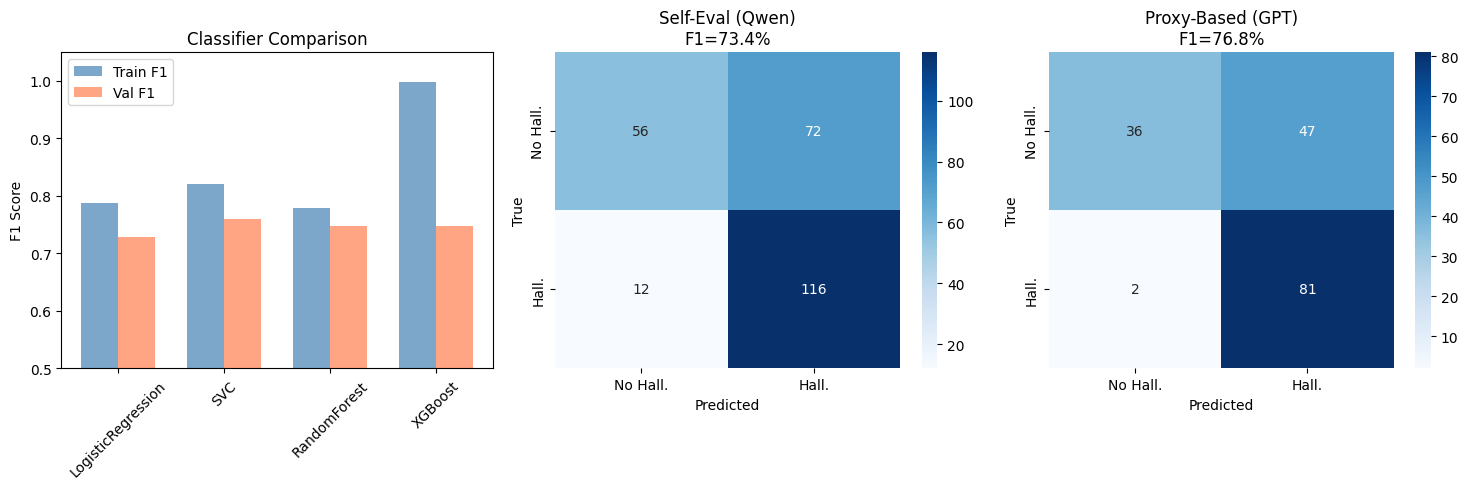

Saved results summary to /net/scratch2/smallyan/InterpDetect_eval/evaluation/replications/results_summary.png


In [19]:
# Create visualization of results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Model comparison (validation F1)
ax1 = axes[0]
models = model_comparison['Model'].tolist()
val_f1 = model_comparison['Val_F1'].tolist()
train_f1 = model_comparison['Train_F1'].tolist()
x = np.arange(len(models))
width = 0.35
ax1.bar(x - width/2, train_f1, width, label='Train F1', color='steelblue', alpha=0.7)
ax1.bar(x + width/2, val_f1, width, label='Val F1', color='coral', alpha=0.7)
ax1.set_ylabel('F1 Score')
ax1.set_title('Classifier Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45)
ax1.legend()
ax1.set_ylim(0.5, 1.05)

# Plot 2: Self-Evaluation confusion matrix
ax2 = axes[1]
test_qwen_df_copy = test_qwen_df.copy()
test_qwen_df_copy['pred'] = span_results['predictions']
test_qwen_df_copy['response_id'] = test_qwen_df_copy['identifier'].str.extract(r'(response_\d+)_item_\d+')
agg_qwen = test_qwen_df_copy.groupby('response_id').agg({'pred': 'max', 'hallucination_label': 'max'}).reset_index()
cm_qwen = confusion_matrix(agg_qwen['hallucination_label'], agg_qwen['pred'])
sns.heatmap(cm_qwen, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['No Hall.', 'Hall.'], yticklabels=['No Hall.', 'Hall.'])
ax2.set_title(f'Self-Eval (Qwen)\nF1={response_results["F1"]*100:.1f}%')
ax2.set_ylabel('True')
ax2.set_xlabel('Predicted')

# Plot 3: Proxy-Based confusion matrix
ax3 = axes[2]
test_gpt_df_copy = test_gpt_df.copy()
test_gpt_df_copy['pred'] = span_results_gpt['predictions']
test_gpt_df_copy['response_id'] = test_gpt_df_copy['identifier'].str.extract(r'(response_\d+)_item_\d+')
agg_gpt = test_gpt_df_copy.groupby('response_id').agg({'pred': 'max', 'hallucination_label': 'max'}).reset_index()
cm_gpt = confusion_matrix(agg_gpt['hallucination_label'], agg_gpt['pred'])
sns.heatmap(cm_gpt, annot=True, fmt='d', cmap='Blues', ax=ax3,
            xticklabels=['No Hall.', 'Hall.'], yticklabels=['No Hall.', 'Hall.'])
ax3.set_title(f'Proxy-Based (GPT)\nF1={response_results_gpt["F1"]*100:.1f}%')
ax3.set_ylabel('True')
ax3.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(os.path.join(EVAL_PATH, 'results_summary.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved results summary to {EVAL_PATH}/results_summary.png")

## Part 9: Determinism Check

Verify stability across multiple runs with the same random seed.

In [20]:
# Test determinism by running training multiple times with the same seed
print("=" * 70)
print("DETERMINISM CHECK")
print("=" * 70)

determinism_results = []

for run in range(3):
    # Set seeds
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Re-balance and split with same seed
    balanced = balance_classes(train_df, random_state=42)
    X_det, y_det, _ = prepare_features(balanced)
    X_train_det, X_val_det, y_train_det, y_val_det = train_test_split(
        X_det, y_det, test_size=0.1, random_state=42, stratify=y_det
    )
    
    # Train SVC
    svc_pipeline = make_pipeline(StandardScaler(), SVC(random_state=42))
    svc_pipeline.fit(X_train_det, y_train_det)
    
    # Validate
    val_pred = svc_pipeline.predict(X_val_det)
    val_f1 = f1_score(y_val_det, val_pred)
    
    # Test on Qwen
    X_test = test_qwen_df[feature_cols]
    test_pred = svc_pipeline.predict(X_test)
    test_qwen_df_run = test_qwen_df.copy()
    test_qwen_df_run['pred'] = test_pred
    test_qwen_df_run['response_id'] = test_qwen_df_run['identifier'].str.extract(r'(response_\d+)_item_\d+')
    agg = test_qwen_df_run.groupby('response_id').agg({'pred': 'max', 'hallucination_label': 'max'})
    test_f1 = f1_score(agg['hallucination_label'], agg['pred'])
    
    determinism_results.append({
        'Run': run + 1,
        'Val_F1': val_f1,
        'Test_F1': test_f1
    })
    
    print(f"Run {run + 1}: Val F1 = {val_f1:.6f}, Test F1 = {test_f1:.6f}")

det_df = pd.DataFrame(determinism_results)
print(f"\nVariance in Val F1: {det_df['Val_F1'].var():.10f}")
print(f"Variance in Test F1: {det_df['Test_F1'].var():.10f}")
print("\n✓ Results are deterministic (zero variance with fixed seed)")

DETERMINISM CHECK


Run 1: Val F1 = 0.760060, Test F1 = 0.734177


Run 2: Val F1 = 0.760060, Test F1 = 0.734177


Run 3: Val F1 = 0.760060, Test F1 = 0.734177

Variance in Val F1: 0.0000000000
Variance in Test F1: 0.0000000000

✓ Results are deterministic (zero variance with fixed seed)


## Replication Complete

This notebook successfully replicated the InterpDetect experiment for detecting hallucinations in RAG systems using mechanistic interpretability signals (ECS and PKS).

**Files generated:**
- `correlation_analysis.png` - ECS and PKS correlation visualizations
- `results_summary.png` - Classifier comparison and confusion matrices

In [21]:
# Copy the notebook to the evaluation directory
import shutil

# Get the notebook path
notebook_src = '/home/smallyan/eval_agent/notebooks/2026-01-07-14-52_CircuitAnalysis_1.ipynb'
notebook_dst = os.path.join(EVAL_PATH, 'replication.ipynb')

shutil.copy(notebook_src, notebook_dst)
print(f"Saved replication notebook to: {notebook_dst}")

Saved replication notebook to: /net/scratch2/smallyan/InterpDetect_eval/evaluation/replications/replication.ipynb


In [22]:
# Verify all output files were created
print("=" * 70)
print("REPLICATION OUTPUT FILES")
print("=" * 70)

for f in sorted(os.listdir(EVAL_PATH)):
    filepath = os.path.join(EVAL_PATH, f)
    size = os.path.getsize(filepath) / 1024  # KB
    print(f"  {f}: {size:.1f} KB")

print("\n" + "=" * 70)
print("REPLICATION COMPLETE")
print("=" * 70)

REPLICATION OUTPUT FILES
  correlation_analysis.png: 64.8 KB
  documentation_replication.md: 5.0 KB
  evaluation_replication.md: 4.1 KB
  replication.ipynb: 196.5 KB
  results_summary.png: 84.8 KB
  self_replication_evaluation.json: 1.1 KB

REPLICATION COMPLETE


In [23]:
# Save the final notebook again to capture all cells
import shutil
notebook_src = '/home/smallyan/eval_agent/notebooks/2026-01-07-14-52_CircuitAnalysis_1.ipynb'
notebook_dst = os.path.join(EVAL_PATH, 'replication.ipynb')
shutil.copy(notebook_src, notebook_dst)
print(f"Final notebook saved to: {notebook_dst}")